In [1]:
from fastai.vision import *
from fastai.utils.ipython import *

In [2]:
from torchvision import transforms
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

<br>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
bs = 16

In [6]:
size = 256

In [7]:
data = (ImageList.from_folder('images/dataset/train/')
       .split_none()
       .label_empty()
       .transform(tfms=None, size=size, resize_method=ResizeMethod.CROP)
       .databunch(bs=bs)
       .normalize())

In [8]:
data

ImageDataBunch;

Train: LabelList (82783 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: images/dataset/train;

Valid: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: images/dataset/train;

Test: None

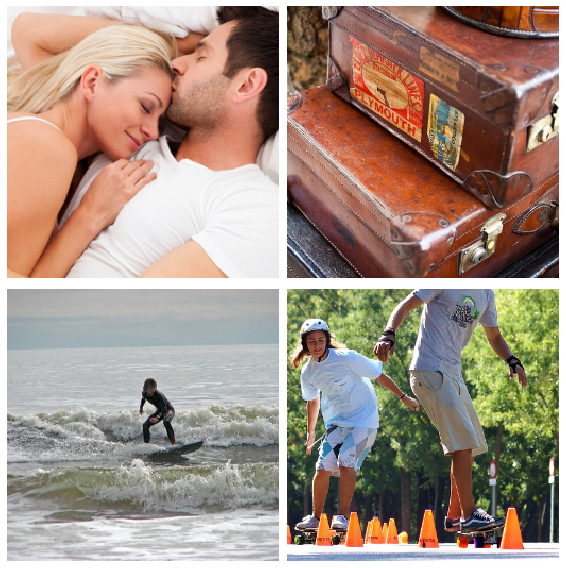

In [9]:
data.show_batch(2)

In [10]:
style_img = open_image('images/style_images/mosaic.jpg')

In [11]:
style_img = style_img.apply_tfms(tfms=None, size=size, resize_method=ResizeMethod.CROP)

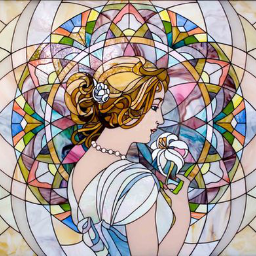

In [12]:
style_img

In [13]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.transformer = TransformerNet()
    
    def forward(self, x):
        y = self.transformer(x)
        
        return x, y

In [14]:
class VggLoss(nn.Module):
    def __init__(self, style_img, content_weight=1e5, style_weight=1e10):
        super().__init__()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.vgg = Vgg16(requires_grad=False).to(device)
        self.mse = nn.MSELoss()
        
        self.style_img = style_img.apply_tfms(tfms=None, size=size, resize_method=ResizeMethod.CROP)
        self.style_img = self.normalize(self.style_img.data)
        self.style_img = self.style_img.repeat(bs, 1,1,1).to(device)
        self.features_style = self.vgg(self.style_img)
        self.gram_style = [utils.gram_matrix(x) for x in self.features_style]
        
    
    def forward(self, x, _):
        x, y = x
        features_x = self.vgg(x)
        features_y = self.vgg(y)
        
        content_loss = self.content_weight * self.mse(features_y.relu2_2, features_x.relu2_2)
        
        style_loss = 0.
        for ft_y, gm_s in zip(features_y, self.gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += self.mse(gm_y, gm_s[:, :, :])
        style_loss *= self.style_weight
        
        return content_loss + style_loss
    
    def normalize(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        normalized = (x - mean) / std
        return normalized
    
    def denormalize(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        denormalized = x * std + mean
        return denormalized

In [29]:
model = MyModel()

In [30]:
loss = VggLoss(style_img)

<br>

In [17]:
learner = Learner(data, model, loss_func=loss, wd=0.0)

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


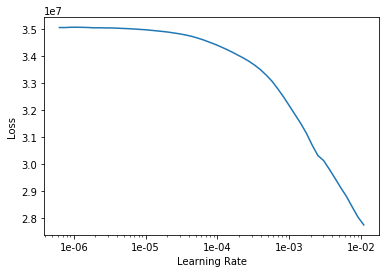

In [19]:
learner.recorder.plot()

In [21]:
learner.fit(epochs=1, lr=0.001, wd=0.0)

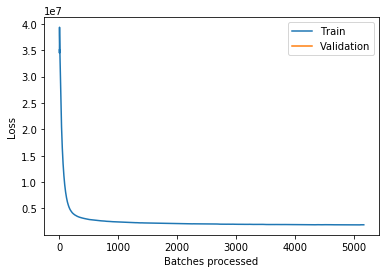

In [22]:
learner.recorder.plot_losses()

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(0.002))

In [23]:
torch.save(model.transformer.state_dict(), 'saved_models/model_fastai_e1.model')

In [24]:
cont_img = open_image('images/content_images/content.JPG')

In [25]:
cont_img = cont_img.apply_tfms(tfms=[], size=512)

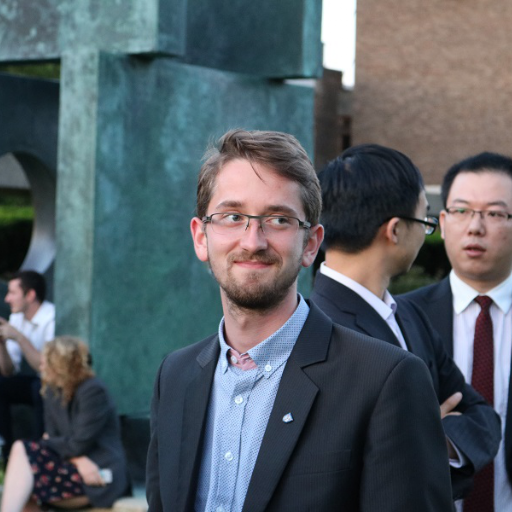

In [26]:
cont_img

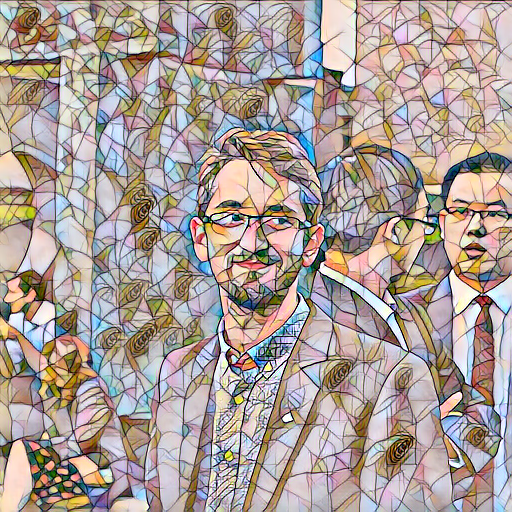

In [27]:
with torch.no_grad():
    img = loss.normalize(cont_img.data.unsqueeze(0))
    output = model.transformer(img.to(device))
    output_img = loss.denormalize(output).squeeze(0).cpu()
    output_img = Image(torch.clamp(output_img, 0.0, 1.0))
output_img

<br>

In [31]:
learner = Learner(data, model, loss_func=loss)

In [32]:
learner.fit_one_cycle(1, max_lr=slice(4e-03))

In [33]:
torch.save(model.transformer.state_dict(), 'saved_models/model_fastai_one_cycle_e1.model')

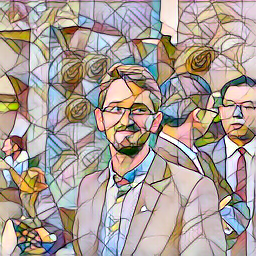

In [50]:
with torch.no_grad():
    img = loss.normalize(cont_img.apply_tfms(tfms=[], size=256).data.unsqueeze(0))
    output = model.transformer(img.to(device))
    output_img = loss.denormalize(output).squeeze(0).cpu()
    output_img = Image(torch.clamp(output_img, 0.0, 1.0))
output_img

<br>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


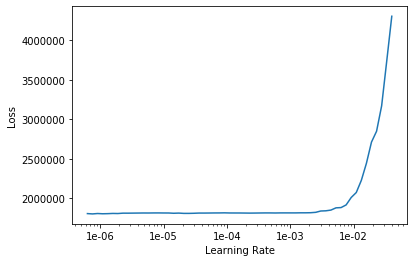

In [42]:
learner.lr_find()
learner.recorder.plot()

In [43]:
torch.cuda.empty_cache()

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(8e-04))

In [49]:
torch.save(model.transformer.state_dict(), 'saved_models/model_fastai_one_cycle_e2.model')

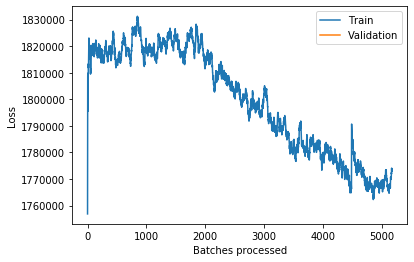

In [47]:
learner.recorder.plot_losses()

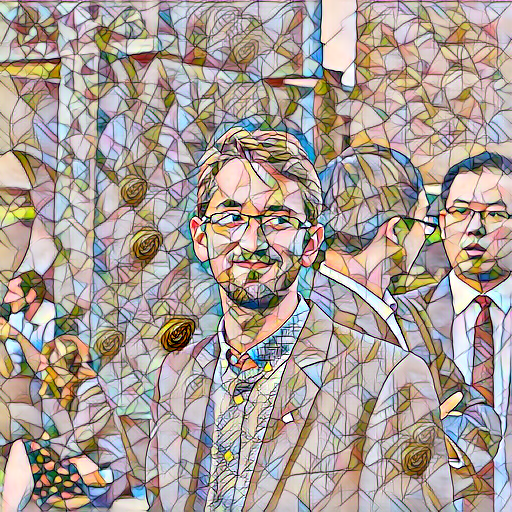

In [48]:
with torch.no_grad():
    img = loss.normalize(cont_img.data.unsqueeze(0))
    output = model.transformer(img.to(device))
    output_img = loss.denormalize(output).squeeze(0).cpu()
    output_img = Image(torch.clamp(output_img, 0.0, 1.0))
output_img